In [1]:
%load_ext autoreload
%autoreload 2

In [170]:
import re

import matplotlib.collections
import matplotlib.patches
import pandas as pd
from pyensembl import EnsemblRelease  # pyensembl install --release 77 --species homo_sapiens
from tqdm import tqdm

from functions import *

# Sanitize grQTLs

In [3]:
# Get grqtls
grqtls = get_grqtls()
def split_region(s):
    match = re.search('^chr(.+):(\d+)(?:)(?:_._.)?$', s)
    return {'Chromosome': str(match.group(1)), 'SNP Locus': int(match.group(2))}
def split_id(s):
    match = re.search('^(.+) --> (.+)_to_(.+)$', s)
    region = split_region(match.group(1))
    tf, tg = match.group(2), match.group(3)
    return {**region, 'TF': tf, 'TG': tg}
for col in split_id(grqtls['id'].iloc[0]):
    grqtls[col] = grqtls['id'].apply(lambda s: split_id(s)[col])
grqtls = grqtls.rename(columns={'celltype': 'Cell Type'})
grqtls = grqtls[['Chromosome', 'SNP Locus', 'TF', 'TG', 'Kind', 'Cell Type']].reset_index(drop=True)

In [4]:
# Get TF and TG locations
# NOTE: Does not account for overlapping genes
ensembl = EnsemblRelease(77)
unknown_genes = []
for kind in ('TF', 'TG'):
    opposite_kind = 'TG' if kind=='TF' else 'TF'
    mask = grqtls['Kind']==f'cis{kind}'
    def get_loci(gene_name):
        try: return ensembl.loci_of_gene_names(gene_name)[0]
        except: unknown_genes.append(gene_name); return None
    # Same
    loci = list(map(get_loci, grqtls.loc[mask, kind]))
    grqtls.loc[mask, 'Gene Chromosome'] = list(map(lambda l: l.contig if l is not None else l, loci))
    equal_or_na = (grqtls.loc[mask, 'Chromosome'] == grqtls.loc[mask, 'Gene Chromosome']) + grqtls.loc[mask, 'Gene Chromosome'].isna()
    assert equal_or_na.sum() == mask.sum()
    grqtls.loc[mask, 'Gene Start'] = list(map(lambda l: int(l.start) if l is not None else l, loci))
    grqtls.loc[mask, 'Gene End'] = list(map(lambda l: int(l.end) if l is not None else l, loci))
    grqtls.loc[mask, 'Gene Strand'] = list(map(lambda l: str(l.strand) if l is not None else l, loci))
    # Opposite
    loci = list(map(get_loci, grqtls.loc[mask, opposite_kind]))
    grqtls.loc[mask, 'Opposite Gene Chromosome'] = list(map(lambda l: l.contig if l is not None else l, loci))
    grqtls.loc[mask, 'Opposite Gene Start'] = list(map(lambda l: int(l.start) if l is not None else l, loci))
    grqtls.loc[mask, 'Opposite Gene End'] = list(map(lambda l: int(l.end) if l is not None else l, loci))
    grqtls.loc[mask, 'Opposite Gene Strand'] = list(map(lambda l: str(l.strand) if l is not None else l, loci))
print(f'{np.unique(unknown_genes).shape[0]} unrecognized genes found: {", ".join(np.unique(unknown_genes))}')

25 unrecognized genes found: ADD3-AS1, ADGRD1, ADGRE2, ADGRE4P, ADGRF5, ADGRG1, ADGRG5, ADGRG6, ADGRL2, ADGRL4, ADGRV1, ANOS1, ARRDC3-AS1, CARMN, FCGR1CP, GPAT3, LINC01619, MIR34AHG, NECTIN2, PLPP3, PLPPR1, SAMD12-AS1, SUSD6, TMIGD3, TNS2


# Sanitize MPRA QTLs

In [5]:
# Read significant MPRA qtls
mpra = pd.read_csv('../../data/mpra_table2.csv')
# Separate locations
for col in split_region(mpra['chr:pos_A0_A1'].iloc[0]):
    mpra[col] = mpra['chr:pos_A0_A1'].apply(lambda s: split_region(s)[col])
# Filter
mpra = mpra.loc[mpra['Disorder']=='AD']
mpra = mpra.loc[mpra['CRISPR q-value']!='–']
# mpra = mpra[['Chromosome', 'SNP Start']]


In [6]:
# Compute significance
# def q_to_min_num(s):
#     entries = s.split('; ')
#     # Special cases
#     entries = ['1' if e=='–' else e for e in entries]
#     entries = [e[1:] if str(e).startswith('<') else e for e in entries]
#     # Main aggregation
#     entries = [e.split(' × ') for e in entries]  # Separate scientific notation
#     entries = [[e[0], e[1].split('−')] if len(e)==2 else e for e in entries]  # Separate powers
#     entries = [[e[0], float(e[1][0])**-float(e[1][1])] if len(e)==2 else e for e in entries]  # Compute powers
#     entries = [[float(e[0])*e[1]] if len(e)==2 else e for e in entries]  # Aggregate scientific
#     entries = [float(e[0]) for e in entries]  # Convert all
#     return min(entries)
# mpra['Significance'] = mpra['CRISPR q-value'].apply(q_to_min_num)

In [7]:
# Fake MPRA data
# mpra = mpra.rename(columns={'Chr', 'Chromosome'})
# mpra = mpra.loc[mpra['frVars']>0]

# mpra = [
#     'chr11:16246208',
#     'chr16:79493142',
# ]
# mpra = pd.DataFrame({'_origin': mpra})
# for col in ('Chromosome', 'SNP Start'):
#     mpra[col] = mpra['_origin'].apply(lambda s: split_region(s)[col])
# mpra = mpra.drop(columns='_origin')

# Find Overlaps

In [10]:
# Parameters
search_distance = int(1e6)
target_cols = ('Chromosome', 'SNP Locus')
# #Overlaps #MPRA/14 SEARCHDIST
# 33        1MPRA    2e4
# 163       2MPRA    1e5
# 390       10MPRA   1e6
chromosome_col, locus_col = target_cols

Found 47923: 100%|███████████████████████████████████████████████| 1041623/1041623 [38:31<00:00, 450.60it/s]


<Axes: >

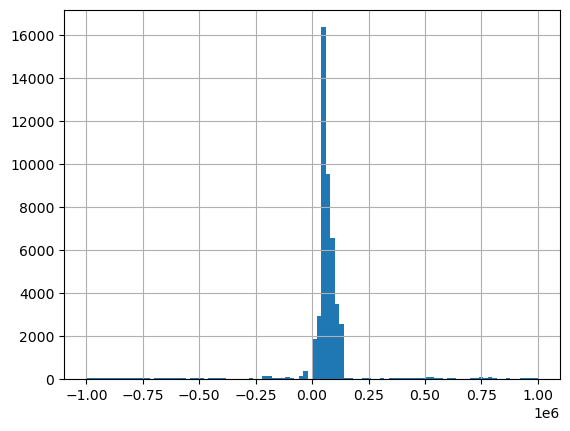

In [ ]:
# Annotate SNP distance
list_cols = ['MPRA ID', 'MPRA Gene Category', 'MPRA SNP Locus', 'Distance']
for col in list_cols+['Overlaps']:
    grqtls[col] = None
for i, r in (pbar := tqdm(grqtls.iterrows(), total=grqtls.shape[0], desc='Found 0')):
    # Filter for missing data
    if np.array([r[col] is None for col in target_cols]).any(): continue

    # Filter by chromosome
    mask = mpra['Chromosome'] == r[chromosome_col]
    if mask.sum()==0: continue

    # Filter by distance
    dist = (r[locus_col] - mpra.loc[mask, 'SNP Locus']).astype(int)
    dist_mask = dist.abs() <= search_distance
    mask[mask] = dist_mask
    if mask.sum()==0: continue

    # Record
    grqtls.at[i, 'MPRA ID'] = mpra.loc[mask, 'chr:pos_A0_A1'].to_list()
    grqtls.at[i, 'MPRA Gene Category'] = mpra.loc[mask, 'Locus'].to_list()
    grqtls.at[i, 'MPRA SNP Locus'] = mpra.loc[mask, 'SNP Locus'].to_list()
    grqtls.at[i, 'Distance'] = dist.loc[dist_mask].to_list()
    grqtls.loc[i, 'Overlaps'] = mask.sum()
    pbar.set_description(f'Found {grqtls["Overlaps"].sum()}')
# Filter and explode
overlapping_grqtls = grqtls.loc[grqtls['Overlaps']>0].explode(list_cols)
# Additional columns
overlapping_grqtls['Absolute Distance'] = overlapping_grqtls['Distance'].abs()
# Histogram
overlapping_grqtls['Distance'].hist(bins=100)

# Annotate Common Gene SNPs

In [ ]:
# Detect if SNP in same gene as MPRA SNP
# Get gene names
# NOTE: Doesn't take intersections into account
# NOTE: # chr2:127886158 corresponds to ENSG00000286873 but is not in pyensembl
gene_names = overlapping_grqtls.apply(lambda r: ensembl.gene_names_at_locus(contig=r[chromosome_col], position=r['MPRA SNP Locus']), axis=1)
gene_names = gene_names.apply(lambda ar: ar[0] if len(ar) > 0 else None)
# Get gene ranges
gene_loci = gene_names.apply(lambda s: ensembl.loci_of_gene_names(s)[0] if s is not None else None)
gene_starts = gene_loci.apply(lambda l: l.start if l is not None else None)
gene_ends = gene_loci.apply(lambda l: l.end if l is not None else None)
assert (
    (overlapping_grqtls['MPRA SNP Locus'] > gene_starts)
    *(overlapping_grqtls['MPRA SNP Locus'] < gene_ends)
    +(gene_loci.isna())).all()
matched_mask = (overlapping_grqtls[locus_col] > gene_starts) * (overlapping_grqtls[locus_col] < gene_ends)
unknown_mask = gene_loci.isna()
print(f'Found {matched_mask.sum()} matched and {unknown_mask.sum()} unknown from {overlapping_grqtls.shape[0]}')
# Add columns
overlapping_grqtls['MPRA Gene'] = gene_names
overlapping_grqtls['MPRA Gene Start'] = gene_starts
overlapping_grqtls['MPRA Gene End'] = gene_ends
overlapping_grqtls['Matching Genes'] = 'No'
overlapping_grqtls.loc[unknown_mask, 'Matching Genes'] = 'Maybe'
overlapping_grqtls.loc[matched_mask, 'Matching Genes'] = 'Yes'

Found 203 matched and 520 unknown from 47923


In [11]:
# Save
overlapping_grqtls.to_csv('../plots/overlapping_grqtls.csv')

# Output Final Results

In [22]:
overlapping_grqtls = pd.read_csv('../plots/overlapping_grqtls.csv', index_col=0)

In [23]:
# Filter to final form over various thresholds
match_gene_map = {'No': 0, 'Maybe': 1, 'Yes': 2}
match_gene_threshold = 'No'
for sig_distance in (int(1e6), int(1e5), int(5e4), int(2e4), int(1e4), int(5e3), int(2e3)):
    print(f'SEARCH DISTANCE {sig_distance:.0e}')
    # Filter by distance
    df = overlapping_grqtls.loc[overlapping_grqtls['Absolute Distance'] < sig_distance]
    # Filter to same gene as MPRA
    df = df.loc[df['Matching Genes'].apply(lambda s: match_gene_map[s]) >= match_gene_map[match_gene_threshold]]
    # Total CLI
    print(f'Overlapping grQTLs:  {df.shape[0]} / {grqtls.shape[0]} ({100.*df.shape[0]/grqtls.shape[0]:.3f}%)')
    # Filtered CLI
    ct_counts = df.groupby('Cell Type')['Chromosome'].count().sort_values(ascending=False)
    print(f'Cell Types:  {", ".join([f"{ct_counts.index[i]} ({ct_counts.iloc[i]})" for i in range(ct_counts.shape[0])])}')
    print(f'Chromosomes:  {", ".join(np.unique(df[chromosome_col]).astype(str))}')
    print(f'MPRA Genes:  {", ".join(np.unique(df["MPRA Gene Category"]))}')
    found_intersections = df['MPRA ID'].unique().shape[0]
    print(f'CRISPR-Validated AD SNPs:  {found_intersections} / {mpra.shape[0]} ({100.*found_intersections/mpra.shape[0]:.3f}%)')
    print()

SEARCH DISTANCE 1e+06
Overlapping grQTLs:  47923 / 1041623 (4.601%)
Cell Types:  micro (6122), oligo (5510), pvm (5055), astro (4960), opc (4112), en_l2_3_it (2476), en_l3_5_it_3 (2365), en_l3_5_it_2 (1879), en_l6_it_1 (1782), in_pvalb (1654), en_l6_ct (1543), immune (1266), in_lamp5_lhx6 (958), in_pvalb_chc (929), endo (886), smc (869), en_l5_et (740), vlmc (683), en_l5_6_np (668), pc (664), in_sst (554), in_lamp5_reln (443), en_l6_it_2 (421), en_l6b (414), en_l3_5_it_1 (402), in_vip (301), in_adarb2 (267)
Chromosomes:  1, 2, 6, 8, 11, 14, 16, 19
MPRA Genes:  APOE, BIN1, CELF1/SPI1, CLU, CR1, HLA-DRB1/5, IQCK, MS4A, SLC24A4/RIN3
CRISPR-Validated AD SNPs:  13 / 14 (92.857%)

SEARCH DISTANCE 1e+05
Overlapping grQTLs:  37891 / 1041623 (3.638%)
Cell Types:  micro (5111), oligo (4342), pvm (4056), astro (4042), opc (3402), en_l2_3_it (2144), en_l3_5_it_3 (2027), en_l3_5_it_2 (1553), en_l6_it_1 (1487), in_pvalb (1470), en_l6_ct (1298), immune (992), in_lamp5_lhx6 (834), in_pvalb_chc (803), 

In [147]:
ct_colors = {
    'immune': '#7e573a',
    'endo': '#ff7740',
    'pc': '#eab5ff',
    'smc': '#5c3b8e',
    'vlmc': '#cc329d',
    'pvm': '#d40000',
    'micro': '#ff5c5e',
    'astro': '#dbb785',
    'opc': '#ffda00',
    'oligo': '#efe8b8',
    'in_sst': '#779900',
    'in_pvalb': '#b6cb33',
    'in_pvalb_chc': '#008e8c',
    'in_adarb2': '#4a967f',
    'in_vip': '#87cd57',
    'in_lamp5_reln': '#1ba8a7',
    'in_lamp5_lhx6': '#75d5bc',
    'en_l5_6_np': '#1a14d5',
    'en_l5_et': '#4f6daf',
    'en_l6b': '#4594d2',
    'en_l6_ct': '#01c2ff',
    'en_l6_it_2': '#0093ff',
    'en_l3_5_it_1': '#9ac1cf',
    'en_l3_5_it_2': '#6a9ff6',
    'en_l3_5_it_3': '#7ac3f2',
    'en_l6_it_1': '#b9d5f0',
    'en_l2_3_it': '#66a9d2'}

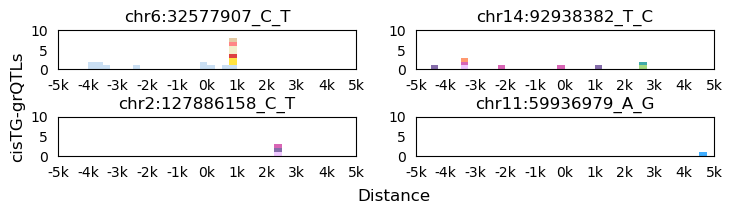

In [ ]:
# Parameters
sig_distance = int(5e3)

# Compute filtered data
proximal_grqtls = overlapping_grqtls.loc[overlapping_grqtls['Absolute Distance'] <= sig_distance]

# Make figure
fig, axs = plt.subplots(2, 2, figsize=(8, 2))
fig.subplots_adjust(wspace=.2, hspace=1.2, left=.08, bottom=.25)
axs = axs.flatten()
fig.supxlabel('Distance')
fig.supylabel('cisTG-grQTLs')
# axs[0].set_xscale('symlog')

# Make plots
unique_mpra_ids = proximal_grqtls['MPRA ID'].unique()
for ax, mpra_id in zip(axs, unique_mpra_ids):
    # Filter data
    one_mpra_grqtls = proximal_grqtls.loc[proximal_grqtls['MPRA ID'] == mpra_id]

    # Histogram
    sns.histplot(
        one_mpra_grqtls, x='Distance',
        bins=40, binrange=(-sig_distance, sig_distance),
        hue='Cell Type', multiple='stack', palette=ct_colors, legend=False,
        # kde=True,
        # color='black',
        edgecolor=None,
        ax=ax)
    
    # Get cell type counts
    ct_counts = one_mpra_grqtls.groupby('Cell Type').count()['Distance'].sort_values()
    
    # Formatting
    xticks = [loc for loc in np.arange(-sig_distance, sig_distance+1, 1000)]
    xticklabels = [f'{int(loc/1000)}k' for loc in xticks]
    # yticks = [loc for loc in np.arange(2, 10, 3)]
    # yticklabels = [f'{loc} grQTLs' for loc in yticks]
    yticks = [loc for loc in np.arange(0, 11, 5)]
    yticklabels = yticks
    ax.set(
        title=mpra_id,
        xlabel=None, xticks=xticks, xticklabels=xticklabels, xlim=(-sig_distance, sig_distance),
        ylabel=None, yticks=yticks, yticklabels=yticklabels, ylim=(0, 10))
    ax.tick_params(axis="both", which="both", left=False, bottom=False)
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    yx_ratio = width / height

    # Draw cell types as circles
    # edge_pad = .01
    # patch_pad = .01
    # max_per_row = 20
    # radius = .015
    # drawn_num = 0
    # patches = []
    # for ct, count in ct_counts.items():
    #     for _ in range(count):
    #         x = edge_pad + (drawn_num % max_per_row) * (2*radius+patch_pad) + radius
    #         y = 1 - yx_ratio*(edge_pad + (drawn_num // max_per_row) * (2*radius+patch_pad) + radius)
    #         patches.append(matplotlib.patches.Ellipse((x, y), 2*radius, yx_ratio*2*radius, facecolor=ct_colors[ct]))
    #         drawn_num += 1
    # ax.add_collection(matplotlib.collections.PatchCollection(patches, match_original=True, transform=ax.transAxes))
fig.savefig('../plots/MPRA_grQTL_overlap.pdf', bbox_inches='tight')
plt.show()

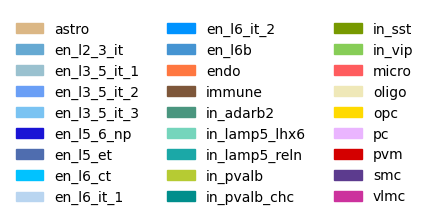

In [182]:
# Create legend
fig, ax = plt.subplots(1, 1, figsize=(1, 1))
patches = []
for ct in sorted(ct_colors):
    patches.append(matplotlib.patches.Patch(color=ct_colors[ct], label=ct))
ax.legend(handles=patches, ncols=3, frameon=False)
# Hide all non-legend elements
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])
fig.savefig('../plots/MPRA_grQTL_overlap_legend.pdf', bbox_inches='tight')
plt.show()